In [2]:
from operator import itemgetter
from itertools import product

import matplotlib.pyplot as plt
import chaospy as cp
import pandas as pd
import numpy as np

We now load the output generated by the estimation of the DSGE model.

In [3]:
data = np.load("bgs0.npz", allow_pickle=True)

We need to spend some effort to put everything in proper data contains to ease processing downstream.

In [35]:
num_draws = 1000  # number of draws from posterior distribution (up to 1,000)
num_periods = 88  # length of simulated time-series
num_paras = 66  # number of parameters

# We first deal with the outcomes under the full policy regime.
index = product(range(num_draws), range(num_periods))
index = pd.MultiIndex.from_tuples(index, names=("Sample", "Period"))
df_policy = pd.DataFrame(
    columns=data["states_labels"], index=index, dtype=np.float
)
for i in range(num_draws):
    df_policy.loc[(i, slice(None)), :] = data["states"][i, :, :]
df_policy = df_policy.astype(np.float)

# We now tackle the samples from the posterior distribution.
para_labels = [str(data["parameters_labels"][i]) for i in range(num_paras)]
index = pd.Index(range(num_draws), name="Sample")
df_para = pd.DataFrame(
    data["parameters"], columns=para_labels, index=index, dtype=np.float
)

We are now ready to tackle the parametric approximation of the posterior distribution. In principle, we need to approximate a 66-dimensional multivariate distribution while allowing for correlation. The process consists of two steps. First, we select a marginal distribution for each parameter and then, second, we combine them using a Gaussian copula. I will now prototype some code for the analysis of the first five parameters which needs to be extended to the full set.

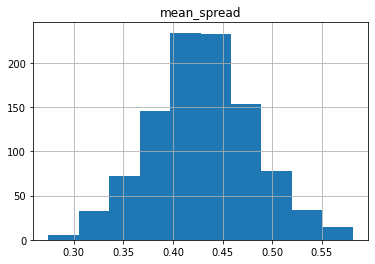

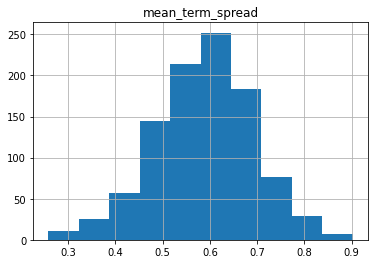

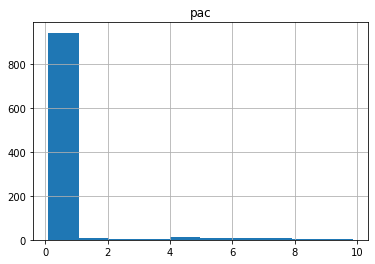

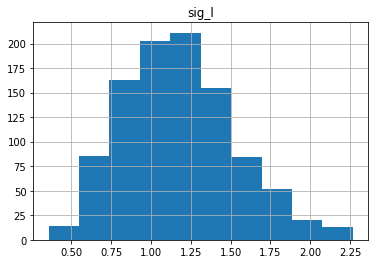

In [36]:
labels = df_para.columns[:5]

for label in labels:
    fig, ax = plt.subplots()

    df_para[label].hist(ax=ax)
    ax.set_title(label)

plt.close()

While appropriate only for some, we will go ahead with simply approximating all of them with a univariate normal distribution and them bind them together with a Normal copula.

In [37]:
marginals = list()

for label in labels:
    spec = df_para[label].describe().to_dict()
    marginals.append(cp.Normal(*itemgetter("mean", "std")(spec)))

distribution = cp.J(*marginals)
R = df_para[labels].corr().values

copula = cp.Nataf(distribution, R)

We can now sample from our approximation of the posterior.

In [38]:
rvs = copula.sample(10000).T

How well are we doing?

* What measures are available?

## How does a UQ analysis based on the approximation compare?

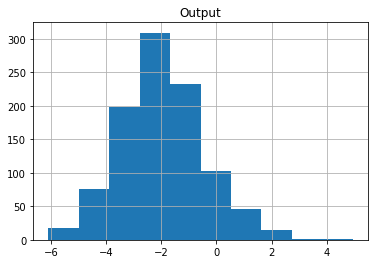

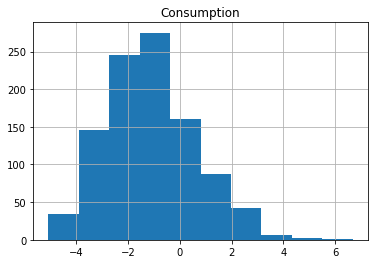

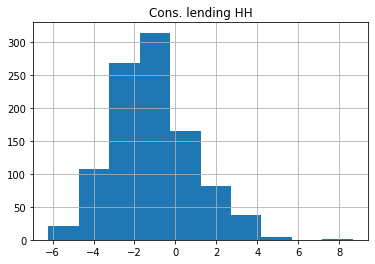

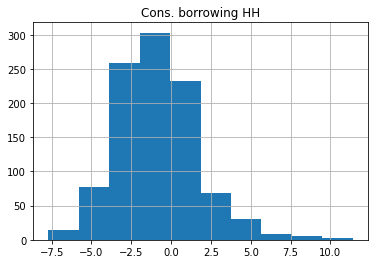

In [39]:
for label in df_policy.columns[:5]:
    fig, ax = plt.subplots()

    df_policy.groupby("Sample")[label].mean().hist()
    ax.set_title(label)

plt.close()

## How an we sample from the conditional distribution?

We will tackle this once we have a proper parametric approximation set up.

# Resources

* [Conditional copula simulation for systemic risk stress testing](https://www.sciencedirect.com/science/article/abs/pii/S016766871300142X)

* [Continuous univariate distributions](https://www.wiley.com/en-us/Continuous+Univariate+Distributions%2C+Volume+1%2C+2nd+Edition-p-9780471584957)

* [Uncertainty analysis with high dimensional dependence modelling](https://onlinelibrary.wiley.com/doi/book/10.1002/0470863072)